# Toward Autonomous and Efficient Cybersecurity: A Multi Objective AutoML based Intrusion Detection System 
This is the code for the paper entitled "[**Toward Autonomous and Efficient Cybersecurity: A Multi Objective AutoML based Intrusion Detection System**](https://ieeexplore.ieee.org/document/11240569/)" published in IEEE Transactions on Machine Learning in Communications and Networking (TMLCN).  
Authors: Li Yang (liyanghart@gmail.com) and Abdallah Shami  

If you find this repository useful in your research, please cite this article as:  
L. Yang and A. Shami, “Towards Autonomous and Efficient Cybersecurity: A Multi Objective AutoML based Intrusion Detection System,” _IEEE Transactions on Machine Learning in Communications and Networking_, pp. 1–21, 2025, doi: [10.1109/TMLCN.2025.3631379](https://ieeexplore.ieee.org/document/11240569/)   

```
@ARTICLE{11240569,
  author={Yang, Li and Shami, Abdallah},
  journal={IEEE Transactions on Machine Learning in Communications and Networking}, 
  title={Towards Autonomous and Efficient Cybersecurity: A Multi-Objective AutoML-based Intrusion Detection System}, 
  year={2025},
  pages={1-21},
  keywords={Computer security;Automated machine learning;Optimization;Internet of Things;Intrusion detection;Feature extraction;Data models;Data analysis;Benchmark testing;Adaptation models;Network Automation;AutoML;Multi-Objective Optimization;Cybersecurity;Intrusion Detection System;IoT},
  doi={10.1109/TMLCN.2025.3631379}}
```


## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import lightgbm as lgb
import xgboost as xgb
import joblib
import os
import time

## Dataset 2: IoTID20
The IoTID20 dataset is publicly available at: https://sites.google.com/view/iot-network-intrusion-dataset/home  

Due to the large size of this dataset and the file size limit of GitHub, the sampled subset of IoTID20 is used. The subsets are in the "Data" folder.  PS: The results might be different from the paper due to the size difference of the dataset.

The IoTID20 dataset represents a significant advancement in cybersecurity datasets for evaluating IDSs in IoT environments. By capturing network traffic from a smart home environment with interconnected IoT devices, this dataset addresses the increasing demand for realistic IoT cybersecurity datasets. A wide range of attack scenarios is available with IoTID20, which includes DoS, Man-in-the-Middle (MITM), scanning, and Mirai botnet variants. IoTID20 is an important resource for developing ML-based IDSs, especially for IoT security research, because of its well-structured features and real-world attack scenarios. 

If you want to use this code on other datasets, just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [2]:
# Read the dataset
df = pd.read_csv("Data/IoTID20_sample_0.05.csv")


In [3]:
# Display the data
df

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,3320,5755,7953,200,554,6,3695,6799,0,2,...,0,0.0,0.000000,0.0,0.0,6799.000000,0.000000,6799.0,6799.0,0
1,12446,25883,10000,203,10101,17,3491,212,3,1,...,0,0.0,0.000000,0.0,0.0,70.666667,0.577350,71.0,70.0,2
2,12731,25883,9020,204,44144,6,3614,60431,5,7,...,0,443.0,326.401593,898.0,121.0,9708.333333,16525.220152,43394.0,1394.0,0
3,46346,25886,56260,69,7100,6,1251,143,0,2,...,0,0.0,0.000000,0.0,0.0,143.000000,0.000000,143.0,143.0,2
4,22794,34651,6302,200,554,6,3672,13406,0,2,...,0,0.0,0.000000,0.0,0.0,13406.000000,0.000000,13406.0,13406.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31284,12170,25885,0,200,0,0,3832,74,1,1,...,0,0.0,0.000000,0.0,0.0,74.000000,0.000000,74.0,74.0,1
31285,17206,29071,7572,200,554,6,3670,1892,0,2,...,0,0.0,0.000000,0.0,0.0,1892.000000,0.000000,1892.0,1892.0,0
31286,12447,25883,56361,203,10101,17,3335,159,0,3,...,0,0.0,0.000000,0.0,0.0,79.500000,6.363961,84.0,75.0,2
31287,46790,25911,443,204,52366,6,1238,153,2,1,...,0,0.0,0.000000,0.0,0.0,76.500000,0.707107,77.0,76.0,2


In [4]:
df.Label.value_counts()

Label
2    20780
4     3720
0     2994
3     2030
1     1765
Name: count, dtype: int64

**Corresponding Attack Types:**  
2 Mirai        &emsp;         415677  -20780  
4 Scan         &emsp;          75265  -3720  
0 DoS          &emsp;          59391  -2994  
3 Normal       &emsp;          40073  -2030  
1 MITM ARP Spoofing  &emsp;    35377  -1765  
Name: Cat, dtype: int64  

## 1. Automated Data Pre-Processing

### Automated normalization
Normalize the range of features to a similar scale to improve data quality

In [5]:
from scipy.stats import shapiro
def Auto_Normalization(df):
    stat, p = shapiro(df)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    numeric_features = df.drop(['Label'],axis = 1).dtypes[df.dtypes != 'object'].index
    
    # The selection strategy is based on the following article: 
    # https://medium.com/@kumarvaishnav17/standardization-vs-normalization-in-machine-learning-3e132a19c8bf
    # Check if the data distribution follows a Gaussian/normal distribution
    # If so, select the Z-score normalization method; otherwise, select the min-max normalization
    # Details are in the paper
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        print('Z-score normalization is automatically chosen and used')
    else:
        print('Sample does not look Gaussian (reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.min()) / (x.max()-x.min()))
        print('Min-max normalization is automatically chosen and used')
    return df
df = Auto_Normalization(df)

Statistics=0.020, p=0.000
Sample does not look Gaussian (reject H0)
Min-max normalization is automatically chosen and used


In [6]:
# Address missing and infinite values
if df.isnull().values.any() or np.isinf(df).values.any(): # if there is any empty or infinite values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace = True)  # Replace empty values with zeros

### Split train set and test set

In [11]:
# Split the dataset into training and testing
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.5, test_size = 0.5, random_state = 0) #shuffle=False

### Machine learning model training

### Training base learners (for comparison purposes): 
decision tree, random forest, extra trees, XGBoost, and LightGBM


#### DT

Training time:  0.06639242172241211 s
Prediction time per sample:  0.0002549074830701078 ms
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1510
           1       1.00      1.00      1.00       869
           2       1.00      1.00      1.00     10362
           3       1.00      1.00      1.00      1023
           4       1.00      1.00      1.00      1881

    accuracy                           1.00     15645
   macro avg       1.00      1.00      1.00     15645
weighted avg       1.00      1.00      1.00     15645

Accuracy of Decision Tree: 0.9997443272611057
Precision of Decision Tree: 0.9997449021950124
Recall of Decision Tree: 0.9997443272611057
Average F1 of Decision Tree: 0.9997443921279386
F1 of Decision Tree for each type of attack: [0.99867462 0.99827685 1.         0.999511   1.        ]


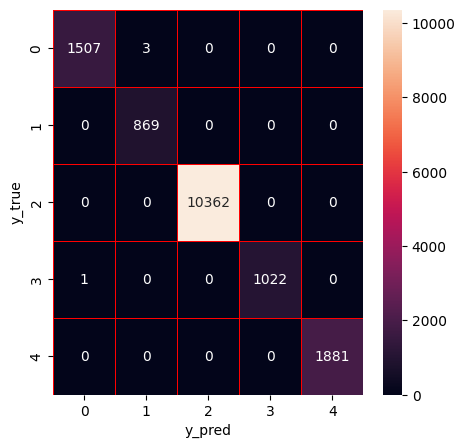

CPU times: total: 266 ms
Wall time: 265 ms


In [12]:
%%time
# Train the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# model training
t1 = time.time()
decision_tree.fit(X_train, y_train)
t2 = time.time()
print("Training time: ", t2-t1, "s")

t3 = time.time()
y_pred = decision_tree.predict(X_test)
t4 = time.time()
print("Prediction time per sample: ", (t4-t3)/len(X_test)*1000, "ms")

# Print metrics
print(classification_report(y_test, y_pred))
print("Accuracy of Decision Tree: " + str(accuracy_score(y_test, y_pred)))
print("Precision of Decision Tree: " + str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of Decision Tree: " + str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of Decision Tree: " + str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of Decision Tree for each type of attack: " + str(f1_score(y_test, y_pred, average=None)))
decision_tree_f1 = f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### RF

Training time:  1.7086138725280762 s
Prediction time per sample:  0.008211611329880566 ms
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1510
           1       1.00      0.97      0.98       869
           2       0.99      1.00      0.99     10362
           3       1.00      0.97      0.99      1023
           4       1.00      0.97      0.98      1881

    accuracy                           0.99     15645
   macro avg       1.00      0.98      0.99     15645
weighted avg       0.99      0.99      0.99     15645

Accuracy of RF: 0.9922019814637264
Precision of RF: 0.9922580866135415
Recall of RF: 0.9922019814637264
Average F1 of RF: 0.9921671032133135
F1 of RF for each type of attack: [0.99800929 0.98073555 0.99443164 0.9851632  0.98409275]


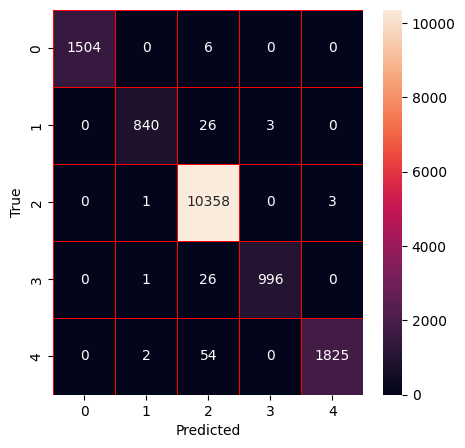

CPU times: total: 2.02 s
Wall time: 2.02 s


In [13]:
%%time

# Train the Random Forest classifier
rf = RandomForestClassifier(random_state=42)
t1 = time.time()
rf.fit(X_train, y_train)
t2 = time.time()
print("Training time: ", t2-t1, "s")

# Make predictions
t3 = time.time()
y_pred = rf.predict(X_test)
t4 = time.time()
print("Prediction time per sample: ", (t4-t3)/len(X_test)*1000, "ms")

# Print metrics
print(classification_report(y_test, y_pred))
print("Accuracy of RF: " + str(accuracy_score(y_test, y_pred)))
print("Precision of RF: " + str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of RF: " + str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of RF: " + str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of RF for each type of attack: " + str(f1_score(y_test, y_pred, average=None)))

# Store F1 scores
rf_f1 = f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#### ET

Training time:  0.18968987464904785 s
Prediction time per sample:  0.002754850866086721 ms
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1510
           1       0.98      0.93      0.95       869
           2       0.98      1.00      0.99     10362
           3       0.99      0.95      0.97      1023
           4       0.98      0.96      0.97      1881

    accuracy                           0.99     15645
   macro avg       0.99      0.97      0.98     15645
weighted avg       0.99      0.99      0.99     15645

Accuracy of ET: 0.9852348993288591
Precision of ET: 0.9852406746492754
Recall of ET: 0.9852348993288591
Average F1 of ET: 0.9851368313917067
F1 of ET for each type of attack: [0.99668215 0.9509746  0.98988155 0.97256858 0.97234899]


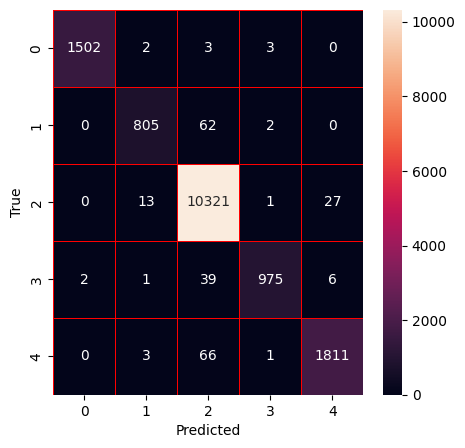

CPU times: total: 1.75 s
Wall time: 423 ms


In [14]:
%%time
# Extra Trees training
et = ExtraTreesClassifier(random_state=42, n_jobs=-1)
t1 = time.time()
et.fit(X_train, y_train)
t2 = time.time()
print("Training time: ", t2 - t1, "s")

# Make predictions
t3 = time.time()
y_pred = et.predict(X_test)
t4 = time.time()
print("Prediction time per sample: ", (t4 - t3) / len(X_test) * 1000, "ms")

# Print metrics
print(classification_report(y_test, y_pred))
print("Accuracy of ET: " + str(accuracy_score(y_test, y_pred)))
print("Precision of ET: " + str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of ET: " + str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of ET: " + str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of ET for each type of attack: " + str(f1_score(y_test, y_pred, average=None)))

# Store F1 scores
et_f1 = f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix (unchanged)
cm = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#### XGBoost

Training time:  1.4041450023651123 s
Prediction time per sample:  0.0008287426761713757 ms
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1510
           1       1.00      1.00      1.00       869
           2       1.00      1.00      1.00     10362
           3       1.00      1.00      1.00      1023
           4       1.00      1.00      1.00      1881

    accuracy                           1.00     15645
   macro avg       1.00      1.00      1.00     15645
weighted avg       1.00      1.00      1.00     15645

Accuracy of XGBoost: 0.9999360818152765
Precision of XGBoost: 0.9999361241171856
Recall of XGBoost: 0.9999360818152765
Average F1 of XGBoost: 0.9999360767663364
F1 of XGBoost for each type of attack: [0.99966898 1.         1.         0.999511   1.        ]


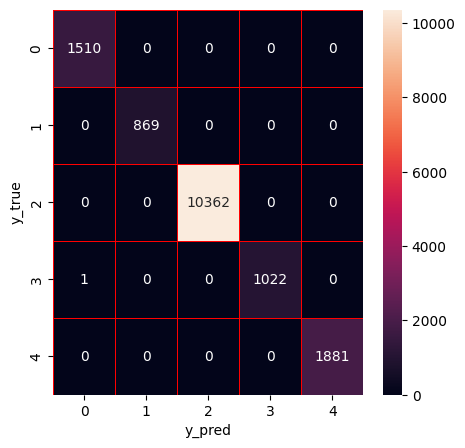

CPU times: total: 20 s
Wall time: 1.65 s


In [15]:
%%time
# Train the XGBoost algorithm

xg = xgb.XGBClassifier(random_state=42, objective="multi:softprob", eval_metric="mlogloss")

# X_train_x = X_train.values
# X_test_x = X_test.values

t1 = time.time()
xg.fit(X_train, y_train)
t2 = time.time()
print("Training time: ", t2-t1, "s")

t3 = time.time()
y_pred = xg.predict(X_test)
t4 = time.time()
print("Prediction time per sample: ", (t4-t3)/len(X_test)*1000, "ms")

print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
xg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### LightGBM

Training time:  0.9635319709777832 s
Prediction time per sample:  0.003378594710294261 ms
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1510
           1       1.00      1.00      1.00       869
           2       1.00      1.00      1.00     10362
           3       1.00      1.00      1.00      1023
           4       1.00      1.00      1.00      1881

    accuracy                           1.00     15645
   macro avg       1.00      1.00      1.00     15645
weighted avg       1.00      1.00      1.00     15645

Accuracy of LightGBM: 0.9992329817833173
Precision of LightGBM: 0.9992352848292326
Recall of LightGBM: 0.9992329817833173
Average F1 of LightGBM: 0.9992333233850133
F1 of LightGBM for each type of attack: [0.99900563 0.99885057 0.99966215 0.99804305 0.99787798]


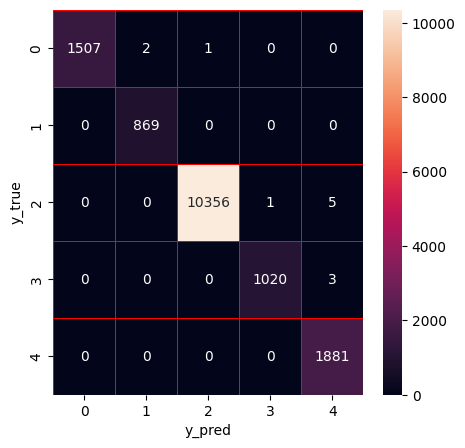

CPU times: total: 15.3 s
Wall time: 1.26 s


In [16]:
%%time
# Train the LightGBM algorithm
lg = lgb.LGBMClassifier(random_state=42)

t1 = time.time()
lg.fit(X_train, y_train)
t2 = time.time()
print("Training time: ", t2-t1, "s")

t3 = time.time()
y_pred = lg.predict(X_test)
t4 = time.time()
print("Prediction time per sample: ", (t4-t3)/len(X_test)*1000, "ms")

print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
lg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Initial model selection: XGBoost and LightGBM are the two best-performing models.

### Automated hybrid data balancing
Automated hybrid data balancing approach integrating SMOTE and ADASYN oversampling techniques to address class imbalance issues.

In [17]:
# Display the class distribution in the training set
pd.Series(y_train).value_counts()

Label
2    10418
4     1839
0     1484
3     1007
1      896
Name: count, dtype: int64

In [18]:
# Proposed hybrid data balancing approach
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

# Class-imbalance detection
average_samples_per_class = sum(Counter(y_train).values()) / len(Counter(y_train)) # Average number of samples per class
target_samples = int(average_samples_per_class / 2) # Target number of samples (average number/2) for each minority class
minority_classes = {k: target_samples for k, v in Counter(y_train).items() if v < target_samples}

# Check if there are minority classes
if minority_classes:
    # Apply SMOTE for 50% of the required samples
    smote = SMOTE(n_jobs=-1, sampling_strategy=minority_classes)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Apply ADASYN for 50% of the required samples
    adasyn = ADASYN(n_jobs=-1, sampling_strategy=minority_classes)
    X_train, y_train = adasyn.fit_resample(X_train, y_train)

# Check the final class distribution
print(pd.Series(y_train).value_counts())


Label
2    10418
4     1839
0     1564
3     1564
1     1564
Name: count, dtype: int64


Training time:  0.9824991226196289 s
Prediction time per sample:  0.004016084387569848 ms
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1510
           1       1.00      1.00      1.00       869
           2       1.00      1.00      1.00     10362
           3       1.00      1.00      1.00      1023
           4       1.00      1.00      1.00      1881

    accuracy                           1.00     15645
   macro avg       1.00      1.00      1.00     15645
weighted avg       1.00      1.00      1.00     15645

Accuracy of LightGBM: 0.9997443272611057
Precision of LightGBM: 0.9997445365097519
Recall of LightGBM: 0.9997443272611057
Average F1 of LightGBM: 0.9997443578048344
F1 of LightGBM for each type of attack: [0.99933775 0.99942496 0.99990348 0.999511   0.99946865]


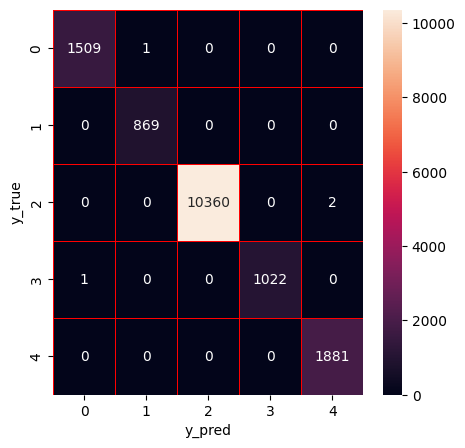

CPU times: total: 15.7 s
Wall time: 1.28 s


In [19]:
%%time
# LightGBM model performance after hybrid data balancing
import lightgbm as lgb
lg = lgb.LGBMClassifier(random_state=42)

t1 = time.time()
lg.fit(X_train, y_train)
t2 = time.time()
print("Training time: ", t2-t1, "s")

t3 = time.time()
y_pred = lg.predict(X_test)
t4 = time.time()
print("Prediction time per sample: ", (t4-t3)/len(X_test)*1000, "ms")

print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
lg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Training time:  1.7337725162506104 s
Prediction time per sample:  0.0007649815170175926 ms
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1510
           1       1.00      1.00      1.00       869
           2       1.00      1.00      1.00     10362
           3       1.00      1.00      1.00      1023
           4       1.00      1.00      1.00      1881

    accuracy                           1.00     15645
   macro avg       1.00      1.00      1.00     15645
weighted avg       1.00      1.00      1.00     15645

Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
Average F1 of XGBoost: 1.0
F1 of XGBoost for each type of attack: [1. 1. 1. 1. 1.]


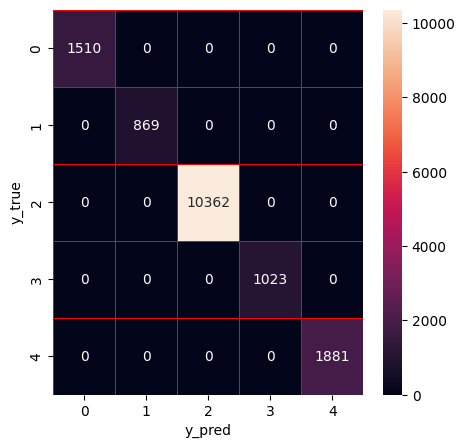

CPU times: total: 25.6 s
Wall time: 1.98 s


In [20]:
%%time
# XGBoost model performance after hybrid data balancing
import xgboost as xgb
xg = xgb.XGBClassifier(random_state=42, objective="multi:softprob", eval_metric="mlogloss")

# X_train_x = X_train.values
# X_test_x = X_test.values

t1 = time.time()
xg.fit(X_train, y_train)
t2 = time.time()
print("Training time: ", t2-t1, "s")

t3 = time.time()
y_pred = xg.predict(X_test)
t4 = time.time()
print("Prediction time per sample: ", (t4-t3)/len(X_test)*1000, "ms")

print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
xg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## 2. Automated Feature Selection
Proposed Optimized Importance and Percentage-based Automated Feature Selection (OIP-AutoFS), which is driven by a Multi-Objective Particle Swarm Optimization (MOPSO) and feature importance. The main purpose of this AutoFS process is to optimize the accumulated importance and percentage of features, thus ensuring that the most significant features are used for model training. 

In [21]:
# Train a baseline LightGBM model on the full feature set to get total feature importance
def get_original_feature_importance(X_train, y_train):
    original_clf = lgb.LGBMClassifier()
    original_clf.fit(X_train, y_train)
    return original_clf.feature_importances_

# Define the objective function (Optimizing Feature Importance and Feature Percentage)
def objective_function(position, X_train, X_test, y_train, y_test, 
                       original_feature_importances, feature_importance_weight=0.9, 
                       feature_percentage_weight=0.1): # Weights for the two objectives, can be tuned
    mask = position > 0.5
    X_train_selected = X_train.iloc[:, mask]
    X_test_selected = X_test.iloc[:, mask]

    if X_train_selected.shape[1] == 0:  # Prevent empty feature selection
        return float('-inf'), 1.0  # Worst possible score

    # Train LightGBM model on selected features
    clf = lgb.LGBMClassifier()
    clf.fit(X_train_selected, y_train)
    
    # Extract the original importance values corresponding to selected features
    selected_feature_importance = original_feature_importances[mask]
    total_selected_importance = np.sum(selected_feature_importance)

    # Normalize feature importance score against the total original importance (range 0-1)
    total_feature_importance_normalized = total_selected_importance / np.sum(original_feature_importances) if np.sum(original_feature_importances) > 0 else 0

    # Compute the percentage of selected features
    num_selected_features = np.sum(mask)
    feature_percentage = num_selected_features / X_train.shape[1]

    # Objective function: Maximizing feature importance and minimizing feature percentage
    score = (
        feature_importance_weight * total_feature_importance_normalized - 
        feature_percentage_weight * feature_percentage
    )

    return score, feature_percentage

# Initialize swarm
def initialize_swarm(num_particles, num_features):
    return [{'position': np.random.rand(num_features), 'velocity': np.random.uniform(-0.1, 0.1, num_features)} for _ in range(num_particles)]

# Update velocity and position with adaptive inertia weight
def update_velocity_position(particle, pbest_position, gbest_position, iteration, max_iterations, 
                             w_max=0.9, w_min=0.4, c1=1.5, c2=1.5):
    
    # **Adaptive inertia weight**: Starts high, decreases over iterations for better convergence
    w = w_max - (w_max - w_min) * (iteration / max_iterations)

    inertia = w * particle['velocity']
    cognitive = c1 * np.random.random() * (pbest_position - particle['position'])
    social = c2 * np.random.random() * (gbest_position - particle['position'])

    inertia = w * particle['velocity']
    cognitive = c1 * np.random.random() * (pbest_position - particle['position'])
    social = c2 * np.random.random() * (gbest_position - particle['position'])
    new_velocity = inertia + cognitive + social
    new_position = particle['position'] + new_velocity

    # Apply bounds
    new_position = np.clip(new_position, 0, 1)
    new_velocity = np.clip(new_velocity, -0.1, 0.1)

    particle['velocity'] = new_velocity
    particle['position'] = new_position

# Main MOPSO function
def mopso(X_train, X_test, y_train, y_test, num_particles=10, max_iterations=20):
    num_features = X_train.shape[1]
    original_feature_importances = get_original_feature_importance(X_train, y_train)  # Get true total feature importance before selection

    swarm = initialize_swarm(num_particles, num_features)
    gbest_score = float('-inf')
    gbest_position = None

    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1}/{max_iterations}")
        
        for particle in swarm:
            fitness = objective_function(particle['position'], X_train, X_test, y_train, y_test, original_feature_importances)

            # Update personal best
            if fitness[0] > particle.get('pbest_score', float('-inf')):
                particle['pbest_score'] = fitness[0]
                particle['pbest_position'] = particle['position']

            # Update global best
            if fitness[0] > gbest_score:
                gbest_score = fitness[0]
                gbest_position = particle['position']

        # Update velocity and position
        for particle in swarm:
            update_velocity_position(particle, particle['pbest_position'], gbest_position, iteration, max_iterations)

    # Get final selected features
    selected_features = gbest_position > 0.5
    selected_feature_names = X_train.columns[selected_features].tolist()
    print("\nSelected Features:", selected_feature_names)

    # Compute final selected feature importance
    selected_feature_importance = original_feature_importances[selected_features]
    final_total_selected_importance = np.sum(selected_feature_importance)

    # Normalize feature importance against the total original importance
    final_relative_feature_importance = final_total_selected_importance / np.sum(original_feature_importances) if np.sum(original_feature_importances) > 0 else 0

    # Compute final percentage of selected features
    final_percentage_selected = np.sum(selected_features) / X_train.shape[1]

    print("\nFinal Relative Accumulated Feature Importance Score (0-1):", final_relative_feature_importance)
    print("Final Percentage of Selected Features:", final_percentage_selected)


    return selected_features, gbest_position, selected_feature_importance


In [22]:
selected_features, gbest_position, selected_feature_importance = mopso(X_train, X_test, y_train, y_test)

Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20
Iteration 20/20

Selected Features: ['Flow_ID', 'Src_IP', 'Src_Port', 'Dst_IP', 'Dst_Port', 'Timestamp', 'Flow_Duration', 'TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Std', 'Flow_Pkts/s', 'Flow_IAT_Min', 'Fwd_IAT_Tot', 'Fwd_IAT_Mean', 'Fwd_IAT_Max', 'Bwd_IAT_Tot', 'Bwd_IAT_Std', 'Bwd_IAT_Max', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags', 'Bwd_URG_Flags', 'Fwd_Header_Len', 'Bwd_Header_Len', 'Bwd_Pkts/s', 'Pkt_Len_Min', 'Pkt_Len_Max', 'Pkt_Len_Std', 'Pkt_Len_Var', 'SYN_Flag_Cnt', 'ACK_Flag_Cnt', 'Down/Up_Ratio', 'Bwd_Seg_Size_Avg', 'Fwd_Byts/b_Avg', 'Fwd_Pkts/b_Avg', 'Fwd_Blk_Rate_Avg', 'Bwd_Blk_Rate_Avg', 'Fwd_Act_Data_Pkts', 'Fwd_Seg_Size_Min', 'Active_Std', 'Acti

In [23]:
# Create new datasets with selected features
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
len(X_train.columns[selected_features].tolist())


46

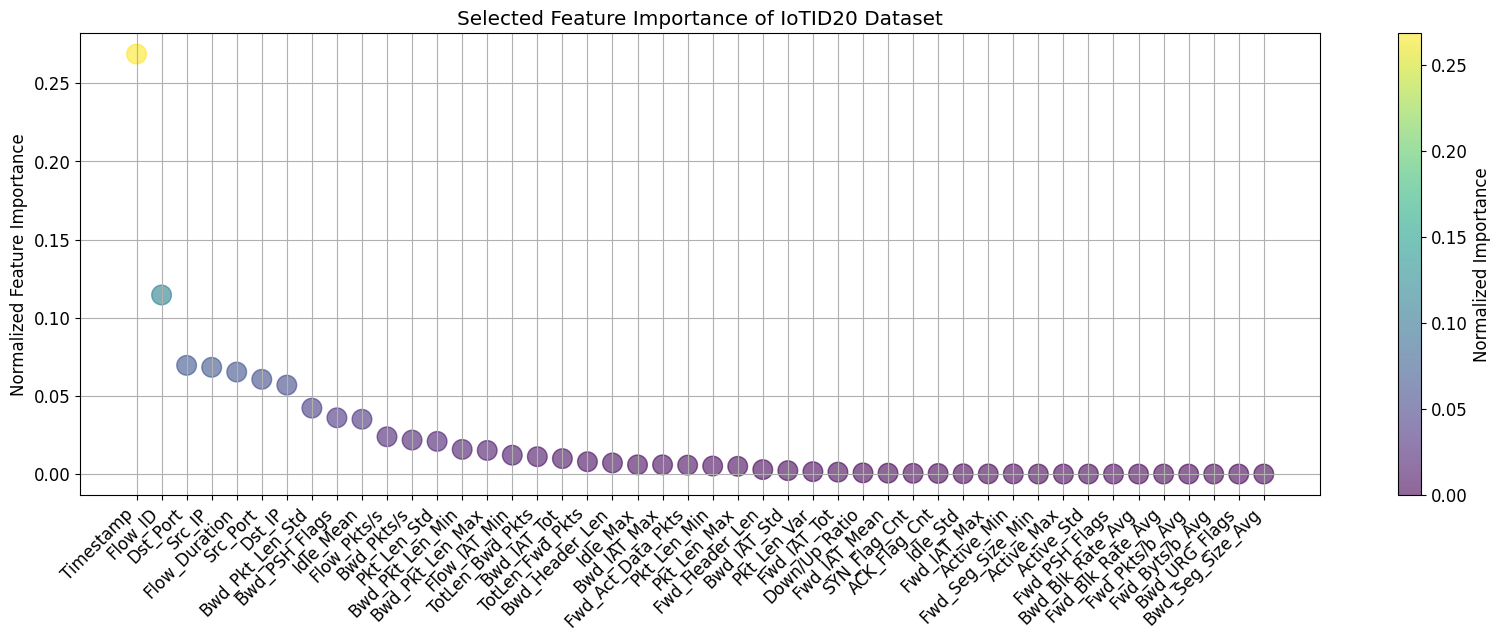

In [24]:
# Plot the feature importance of the selected features
plt.rcParams.update({'font.size': 12})

# Create a DataFrame for easier plotting
features = pd.DataFrame({
    'Feature': X_train.columns[selected_features],
    'Importance': selected_feature_importance
})

# Normalize to relative importance within the selected feature set
imp_sum = features['Importance'].sum()
if imp_sum > 0:
    features['Importance'] = features['Importance'] / imp_sum
else:
    n = len(features)
    features['Importance'] = 1.0 / n if n > 0 else 0.0

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(20, 6))
scatter = plt.scatter(x='Feature', y='Importance', s=200, c='Importance', cmap='viridis', alpha=0.6, data=features)
plt.colorbar(scatter, label='Normalized Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Selected Feature Importance of IoTID20 Dataset')
plt.ylabel('Normalized Feature Importance')
plt.grid(True)
plt.show()

Training time:  0.778771162033081 s
Prediction time per sample:  0.002966798810998484 ms
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1510
           1       1.00      1.00      1.00       869
           2       1.00      1.00      1.00     10362
           3       1.00      1.00      1.00      1023
           4       1.00      1.00      1.00      1881

    accuracy                           1.00     15645
   macro avg       1.00      1.00      1.00     15645
weighted avg       1.00      1.00      1.00     15645

Accuracy of LightGBM: 0.9996804090763822
Precision of LightGBM: 0.999681025087181
Recall of LightGBM: 0.9996804090763822
Average F1 of LightGBM: 0.999680527968885
F1 of LightGBM for each type of attack: [0.99966876 0.99942496 0.99980695 1.         0.99893787]


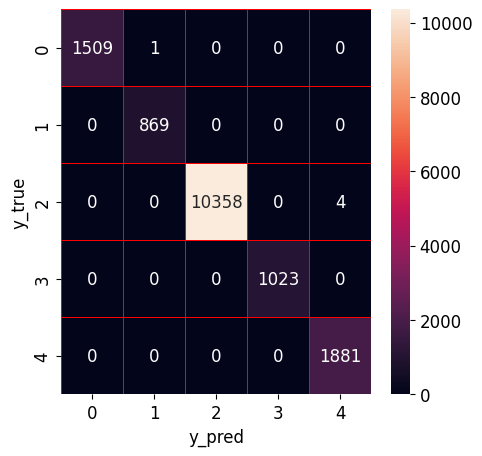

CPU times: total: 12.6 s
Wall time: 1.06 s


In [25]:
%%time
# LightGBM model performance after AutoDP and AutoFS
import lightgbm as lgb
lg = lgb.LGBMClassifier(random_state=42)

t1 = time.time()
lg.fit(X_train_selected, y_train)
t2 = time.time()
print("Training time: ", t2-t1, "s")

t3 = time.time()
y_pred = lg.predict(X_test_selected)
t4 = time.time()
print("Prediction time per sample: ", (t4-t3)/len(X_test)*1000, "ms")

print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
lg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Training time:  1.1842472553253174 s
Prediction time per sample:  0.0007650119955831536 ms
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1510
           1       1.00      1.00      1.00       869
           2       1.00      1.00      1.00     10362
           3       1.00      1.00      1.00      1023
           4       1.00      1.00      1.00      1881

    accuracy                           1.00     15645
   macro avg       1.00      1.00      1.00     15645
weighted avg       1.00      1.00      1.00     15645

Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
Average F1 of XGBoost: 1.0
F1 of XGBoost for each type of attack: [1. 1. 1. 1. 1.]


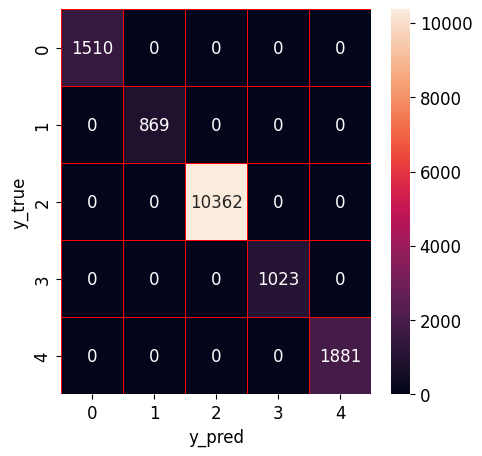

CPU times: total: 17.8 s
Wall time: 1.42 s


In [26]:
%%time
# XGBoost model performance after AutoDP and AutoFS
import xgboost as xgb
xg = xgb.XGBClassifier(random_state=42, objective="multi:softprob", eval_metric="mlogloss")

# X_train_x = X_train.values
# X_test_x = X_test.values

t1 = time.time()
xg.fit(X_train_selected, y_train)
t2 = time.time()
print("Training time: ", t2-t1, "s")

t3 = time.time()
y_pred = xg.predict(X_test_selected)
t4 = time.time()
print("Prediction time per sample: ", (t4-t3)/len(X_test)*1000, "ms")

print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
xg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## 3. Model Selection and Hyperparameter Optimization
The automated model learning and optimization using the proposed OPCE-CASH method is the final phase, a critical step where XGBoost and LightGBM are automatically optimized and selected using the MOPSO model. This phase aims to optimize the F1-score (representing model effectiveness), confidence values (representing model reliability), and execution time (indicating model complexity). 

### Optimize the LightGBM model

In [27]:
# Display the default hyperparameters of LightGBM
lg.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [28]:
# Write the MOPSO algorithm to optimize LightGBM hyperparameters

counter = 0  # Declare this at the top-level script
# Define the objective function (Optimizing F1 Score, Average Confidence, and Training Time)
def objective_function(position, X_train, X_test, y_train, y_test, f1_weight=0.90, confidence_weight=0.05, time_weight=0.05):
    global counter  # Declare counter as global to modify it
    counter += 1  # Increment counter
    
    start_time = time.time()

    # Apply hard constraints
    position[0] = np.clip(position[0], 50, 200)  # n_estimators
    position[1] = np.clip(position[1], 5, 100)    # max_depth
    position[2] = np.clip(position[2], 0.01, 0.3)  # learning_rate
    position[3] = np.clip(position[3], 10, 50)   # num_leaves
    position[4] = np.clip(position[4], 10, 50)   # min_child_samples

    hyperparams = {
        'n_estimators': int(position[0]),
        'max_depth': int(position[1]),
        'learning_rate': position[2],
        'num_leaves': int(position[3]),
        'min_child_samples': int(position[4])
    }

    print(f"Evaluation {counter}: Hyperparameters before training:", hyperparams)  # Debugging line

    clf = lgb.LGBMClassifier(**hyperparams, random_state=42)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    proba = clf.predict_proba(X_test)
    
    f1 = f1_score(y_test, predictions, average='weighted')
    negative_f1 = -f1 * f1_weight
    
    avg_confidence = np.mean(np.max(proba, axis=1))
    negative_avg_confidence = -avg_confidence * confidence_weight
    
    elapsed_time = time.time() - start_time
    weighted_elapsed_time = elapsed_time * time_weight
    
    return negative_f1, negative_avg_confidence, weighted_elapsed_time



# Initialize swarm
def initialize_swarm(num_particles):
    return [{'position': np.array([100, 10, 0.1, 31, 20]) + np.random.uniform(-10, 10, 5), 
             'velocity': np.random.uniform(-0.1, 0.1, 5)} for _ in range(num_particles)]

# Update velocity and position with adaptive inertia weight
def update_velocity_position(particle, pbest_position, gbest_position, iteration, max_iterations, 
                             w_max=0.9, w_min=0.4, c1=1.5, c2=1.5):
    
    # **Adaptive inertia weight**: Starts high, decreases over iterations for better convergence
    w = w_max - (w_max - w_min) * (iteration / max_iterations)

    inertia = w * particle['velocity']
    cognitive = c1 * np.random.random() * (pbest_position - particle['position'])
    social = c2 * np.random.random() * (gbest_position - particle['position'])
    
    new_velocity = inertia + cognitive + social
    new_position = particle['position'] + new_velocity
    
    # Apply constraints
    new_position[0] = np.clip(new_position[0], 50, 200)  # n_estimators
    new_position[1] = np.clip(new_position[1], 5, 100)    # max_depth
    new_position[2] = np.clip(new_position[2], 0.01, 0.3)  # learning_rate
    new_position[3] = np.clip(new_position[3], 10, 50)   # num_leaves
    new_position[4] = np.clip(new_position[4], 10, 50)   # min_child_samples

    particle['velocity'] = new_velocity
    particle['position'] = new_position


# Main MOPSO function
def mopso(X_train, X_test, y_train, y_test, num_particles=20, max_iterations=20):
    swarm = initialize_swarm(num_particles)
    gbest_score = np.array([float('inf')] * 3)
    gbest_position = None

    for iteration in range(max_iterations):
        for particle in swarm:
            fitness = np.array(objective_function(particle['position'], X_train, X_test, y_train, y_test))

            if np.sum(fitness) < np.sum(particle.get('pbest_score', np.array([float('inf')] * 3))):
                particle['pbest_score'] = fitness
                particle['pbest_position'] = particle['position']

            if np.sum(fitness) < np.sum(gbest_score):
                gbest_score = fitness
                gbest_position = particle['position']

        for particle in swarm:
            update_velocity_position(particle, particle['pbest_position'], gbest_position, iteration, max_iterations)

    
    print(f"Optimal hyperparameters are n_estimators: {int(gbest_position[0])}, max_depth: {int(gbest_position[1])}, learning_rate: {gbest_position[2]}, num_leaves: {int(gbest_position[3])}, min_child_samples: {int(gbest_position[4])}")

    return {
        'n_estimators': int(gbest_position[0]),
        'max_depth': int(gbest_position[1]),
        'learning_rate': gbest_position[2],
        'num_leaves': int(gbest_position[3]),
        'min_child_samples': int(gbest_position[4])
    }




In [29]:
# Running MOPSO
best_hyperparams = mopso(X_train_selected, X_test_selected, y_train, y_test)

Evaluation 1: Hyperparameters before training: {'n_estimators': 91, 'max_depth': 17, 'learning_rate': 0.3, 'num_leaves': 40, 'min_child_samples': 25}
Evaluation 2: Hyperparameters before training: {'n_estimators': 91, 'max_depth': 17, 'learning_rate': 0.01, 'num_leaves': 38, 'min_child_samples': 28}
Evaluation 3: Hyperparameters before training: {'n_estimators': 104, 'max_depth': 5, 'learning_rate': 0.3, 'num_leaves': 37, 'min_child_samples': 19}
Evaluation 4: Hyperparameters before training: {'n_estimators': 93, 'max_depth': 5, 'learning_rate': 0.01, 'num_leaves': 29, 'min_child_samples': 18}
Evaluation 5: Hyperparameters before training: {'n_estimators': 98, 'max_depth': 18, 'learning_rate': 0.01, 'num_leaves': 39, 'min_child_samples': 29}
Evaluation 6: Hyperparameters before training: {'n_estimators': 91, 'max_depth': 5, 'learning_rate': 0.01, 'num_leaves': 38, 'min_child_samples': 13}
Evaluation 7: Hyperparameters before training: {'n_estimators': 103, 'max_depth': 5, 'learning_rat

Training time:  0.3052701950073242 s
Prediction time per sample:  0.002039915153720425 ms
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1510
           1       1.00      1.00      1.00       869
           2       1.00      1.00      1.00     10362
           3       1.00      1.00      1.00      1023
           4       1.00      1.00      1.00      1881

    accuracy                           1.00     15645
   macro avg       1.00      1.00      1.00     15645
weighted avg       1.00      1.00      1.00     15645

Accuracy of LightGBM: 0.9998082454458294
Precision of LightGBM: 0.9998085451530621
Recall of LightGBM: 0.9998082454458294
Average F1 of LightGBM: 0.9998082251200284
F1 of LightGBM for each type of attack: [0.99900563 0.99885057 0.99995175 1.         1.        ]


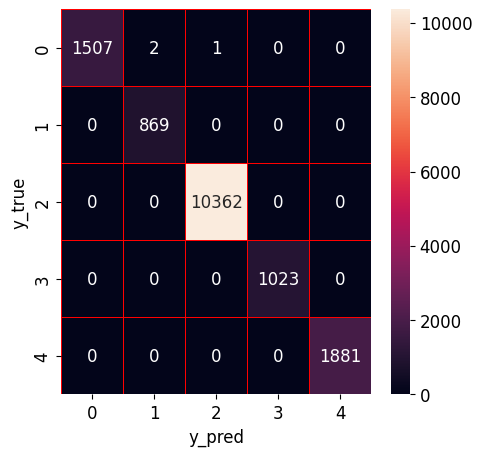

CPU times: total: 4.48 s
Wall time: 575 ms


In [30]:
%%time
# LightGBM model performance
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train the LightGBM algorithm with the best hyperparameters
lg = lgb.LGBMClassifier(**best_hyperparams, random_state=42)

t1 = time.time()
lg.fit(X_train_selected, y_train)
t2 = time.time()
print("Training time: ", t2-t1, "s")

t3 = time.time()
y_pred = lg.predict(X_test_selected)
t4 = time.time()
print("Prediction time per sample: ", (t4-t3)/len(X_test)*1000, "ms")

print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [31]:
# Save the LightGBM model and report its size and average confidence
import joblib
import os

joblib.dump(lg, "lightgbm_model_all.pkl")
lgb_model_size = os.path.getsize("lightgbm_model_all.pkl") / (1024 * 1024)
print(f"LightGBM Model Size: {lgb_model_size:.2f} MB")

# Predict probabilities
y_proba = lg.predict_proba(X_test_selected)

# Compute average confidence
avg_conf = np.mean(np.max(y_proba, axis=1))
print(f"Average Confidence: {avg_conf:.4f}")

from sklearn.calibration import calibration_curve
import numpy as np

def compute_ece(y_true, y_proba, n_bins=10):
    y_pred_class = np.argmax(y_proba, axis=1)
    correct = (np.array(y_true) == y_pred_class).astype(int)
    confidence = np.max(y_proba, axis=1)

    prob_true, prob_pred = calibration_curve(correct, confidence, n_bins=n_bins)
    bin_counts, _ = np.histogram(confidence, bins=n_bins)
    bin_weights = bin_counts[:len(prob_true)] / np.sum(bin_counts)

    ece = np.sum(np.abs(prob_true - prob_pred) * bin_weights)
    return ece

ece = compute_ece(y_test, y_proba)
print(f"ECE: {ece:.4f}")

from sklearn.utils import resample

def bootstrap_ci(data, n_bootstraps=1000, alpha=0.05):
    boot_means = [np.mean(resample(data)) for _ in range(n_bootstraps)]
    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper

confidences = np.max(y_proba, axis=1)
ci_lower, ci_upper = bootstrap_ci(confidences)
print(f"95% CI for Avg Confidence: [{ci_lower:.4f}, {ci_upper:.4f}]")


LightGBM Model Size: 0.37 MB
Average Confidence: 0.9999
ECE: 0.0000
95% CI for Avg Confidence: [0.9999, 1.0000]


### Optimize the XGBoost model

In [32]:
# Display the default hyperparameters of XGBoost
xg.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'mlogloss',
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [34]:
# Write the MOPSO algorithm to optimize XGBoost hyperparameters

counter = 0  # Declare this at the top-level script
# Define the objective function (Optimizing F1 Score, Average Confidence, and Training Time)
def objective_function(position, X_train, X_test, y_train, y_test, f1_weight=0.95, confidence_weight=0.01, time_weight=0.04):
# def objective_function(position, X_train, X_test, y_train, y_test, f1_weight=0.8, confidence_weight=0.05, time_weight=0.15):
    global counter  # Declare counter as global to modify it
    counter += 1  # Increment counter
    
    start_time = time.time()

    # Apply hard constraints
    position[0] = np.clip(position[0], 50, 200)  # n_estimators
    position[1] = np.clip(position[1], 5, 50)    # max_depth
    position[2] = np.clip(position[2], 0.01, 0.3)  # learning_rate

    hyperparams = {
        'n_estimators': int(position[0]),
        'max_depth': int(position[1]),
        'learning_rate': position[2]
    }

    print(f"Evaluation {counter}: Hyperparameters before training:", hyperparams)  # Debugging line

    clf = xgb.XGBClassifier(**hyperparams, random_state=42, objective="multi:softprob", eval_metric="mlogloss")
    # clf.fit(X_train, y_train)
    clf.fit(X_train, y_train,         
    eval_set=[(X_test, y_test)],
        early_stopping_rounds=10, verbose=False)  # check whether to set early_stopping_rounds to reduce time
    
    predictions = clf.predict(X_test)
    proba = clf.predict_proba(X_test)
    
    f1 = f1_score(y_test, predictions, average='weighted')
    negative_f1 = -f1 * f1_weight
    
    avg_confidence = np.mean(np.max(proba, axis=1))
    negative_avg_confidence = -avg_confidence * confidence_weight
    
    elapsed_time = time.time() - start_time
    weighted_elapsed_time = elapsed_time * time_weight
    
    return negative_f1, negative_avg_confidence, weighted_elapsed_time

def initialize_swarm(num_particles):
    return [{'position': np.array([100, 10, 0.1]) + np.random.uniform(-10, 10, 3), 
             'velocity': np.random.uniform(-0.1, 0.1, 3)} for _ in range(num_particles)]

# Update velocity and position with adaptive inertia weight
def update_velocity_position(particle, pbest_position, gbest_position, iteration, max_iterations, 
                             w_max=0.9, w_min=0.4, c1=1.5, c2=1.5):
    
    # **Adaptive inertia weight**: Starts high, decreases over iterations for better convergence
    w = w_max - (w_max - w_min) * (iteration / max_iterations)

    inertia = w * particle['velocity']
    cognitive = c1 * np.random.random() * (pbest_position - particle['position'])
    social = c2 * np.random.random() * (gbest_position - particle['position'])

    # Compute new velocity
    new_velocity = inertia + cognitive + social

    # Compute new position
    new_position = particle['position'] + new_velocity

    # **Apply constraints to hyperparameters**
    new_position[0] = np.clip(new_position[0], 50, 200)  # n_estimators
    new_position[1] = np.clip(new_position[1], 5, 50)    # max_depth (Reduced upper limit)
    new_position[2] = np.clip(new_position[2], 0.01, 0.3)  # learning_rate (Narrowed range)

    # Update particle velocity and position
    particle['velocity'] = new_velocity
    particle['position'] = new_position



# Main MOPSO function
def mopso(X_train, X_test, y_train, y_test, num_particles=10, max_iterations=20):
    swarm = initialize_swarm(num_particles)
    gbest_score = np.array([float('inf')] * 3)
    gbest_position = None
    
    for iteration in range(max_iterations):
        for particle in swarm:
            fitness = np.array(objective_function(particle['position'], X_train, X_test, y_train, y_test))
            
            if np.sum(fitness) < np.sum(particle.get('pbest_score', np.array([float('inf')] * 3))):
                particle['pbest_score'] = fitness
                particle['pbest_position'] = particle['position']
                
            if np.sum(fitness) < np.sum(gbest_score):
                gbest_score = fitness
                gbest_position = particle['position']
                
        for particle in swarm:
            update_velocity_position(particle, particle['pbest_position'], gbest_position, iteration, max_iterations)
    
    print(f"Optimal hyperparameters are n_estimators: {int(gbest_position[0])}, max_depth: {int(gbest_position[1])}, learning_rate: {gbest_position[2]}")
    
    return {
        'n_estimators': int(gbest_position[0]),
        'max_depth': int(gbest_position[1]),
        'learning_rate': gbest_position[2]
    }




In [35]:
# Running MOPSO
best_hyperparams = mopso(X_train_selected, X_test_selected, y_train, y_test)

Evaluation 1: Hyperparameters before training: {'n_estimators': 106, 'max_depth': 17, 'learning_rate': 0.3}
Evaluation 2: Hyperparameters before training: {'n_estimators': 98, 'max_depth': 13, 'learning_rate': 0.3}
Evaluation 3: Hyperparameters before training: {'n_estimators': 108, 'max_depth': 7, 'learning_rate': 0.3}
Evaluation 4: Hyperparameters before training: {'n_estimators': 109, 'max_depth': 18, 'learning_rate': 0.01}
Evaluation 5: Hyperparameters before training: {'n_estimators': 96, 'max_depth': 5, 'learning_rate': 0.3}
Evaluation 6: Hyperparameters before training: {'n_estimators': 91, 'max_depth': 6, 'learning_rate': 0.3}
Evaluation 7: Hyperparameters before training: {'n_estimators': 101, 'max_depth': 9, 'learning_rate': 0.01}
Evaluation 8: Hyperparameters before training: {'n_estimators': 91, 'max_depth': 12, 'learning_rate': 0.01}
Evaluation 9: Hyperparameters before training: {'n_estimators': 107, 'max_depth': 17, 'learning_rate': 0.3}
Evaluation 10: Hyperparameters be

Training time:  0.9129734039306641 s
Prediction time per sample:  0.0005737437574045847 ms
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1510
           1       1.00      1.00      1.00       869
           2       1.00      1.00      1.00     10362
           3       1.00      1.00      1.00      1023
           4       1.00      1.00      1.00      1881

    accuracy                           1.00     15645
   macro avg       1.00      1.00      1.00     15645
weighted avg       1.00      1.00      1.00     15645

Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
Average F1 of XGBoost: 1.0
F1 of XGBoost for each type of attack: [1. 1. 1. 1. 1.]


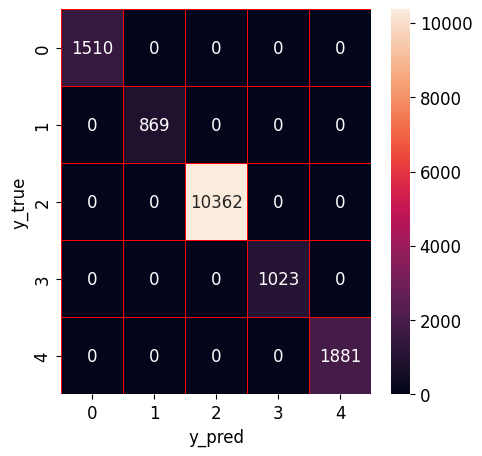

CPU times: total: 13.9 s
Wall time: 1.16 s


In [36]:
%%time
# XGBoost model performance
xg = xgb.XGBClassifier(**best_hyperparams, random_state=42, objective="multi:softprob", eval_metric="mlogloss")

# X_train_x = X_train.values
# X_test_x = X_test.values

t1 = time.time()
xg.fit(X_train_selected, y_train)
t2 = time.time()
print("Training time: ", t2-t1, "s")

t3 = time.time()
y_pred = xg.predict(X_test_selected)
t4 = time.time()
print("Prediction time per sample: ", (t4-t3)/len(X_test)*1000, "ms")

print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
xg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [37]:
# Save the XGBoost model and report its size and average confidence

# Save model
joblib.dump(xg, "xgboost_model_all.pkl")

# Check file size in MB
xgb_model_size = os.path.getsize("xgboost_model_all.pkl") / (1024 * 1024)
print(f"XGBoost Model Size: {xgb_model_size:.2f} MB")

# Get predicted probabilities
y_proba = xg.predict_proba(X_test_selected)

# Compute average confidence
avg_conf = np.mean(np.max(y_proba, axis=1))
print(f"Average Confidence: {avg_conf:.4f}")

from sklearn.calibration import calibration_curve
import numpy as np

def compute_ece(y_true, y_proba, n_bins=10):
    y_pred_class = np.argmax(y_proba, axis=1)
    correct = (np.array(y_true) == y_pred_class).astype(int)
    confidence = np.max(y_proba, axis=1)

    prob_true, prob_pred = calibration_curve(correct, confidence, n_bins=n_bins)
    bin_counts, _ = np.histogram(confidence, bins=n_bins)
    bin_weights = bin_counts[:len(prob_true)] / np.sum(bin_counts)

    ece = np.sum(np.abs(prob_true - prob_pred) * bin_weights)
    return ece

ece = compute_ece(y_test, y_proba)
print(f"ECE: {ece:.4f}")

from sklearn.utils import resample

def bootstrap_ci(data, n_bootstraps=1000, alpha=0.05):
    boot_means = [np.mean(resample(data)) for _ in range(n_bootstraps)]
    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper

confidences = np.max(y_proba, axis=1)
ci_lower, ci_upper = bootstrap_ci(confidences)
print(f"95% CI for Avg Confidence: [{ci_lower:.4f}, {ci_upper:.4f}]")



XGBoost Model Size: 0.24 MB
Average Confidence: 0.9996
ECE: 0.0001
95% CI for Avg Confidence: [0.9994, 0.9997]
